# Cluster Analysis
Andrew E. Davidson  
aedavids@ucsc.edu
1/24/24

ref: intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb 


In testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb we trained a logistic regression model using signature genes for LUAD and LUSC from /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/upsetPlot.out/best10_from_best500FindAllDegree1_wl500.intersection.dict

sensitivity was no not good.

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)

import scikitplot as skplt
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler # LabelEncoder, 
# from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

/data/tmp/ipykernel_2586364/4059348310.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/lungCancerPCA_ClusterAnalysis.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/lungCancerPCA_ClusterAnalysis.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/lungCancerPCA_ClusterAnalysis.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavid

In [3]:
from analysis.utilities import findSignatureGenesForPipelineStage #loadDictionary, loadPipelineStageIntersectionDict
from plots.scatterPlots import createScatterPlot
from intraExtraRNA.elifeUtilities import loadCounts, loadMetaData, selectFeatures
from intraExtraRNA.utilities import selectSamples # load, 

# load elife data

In [4]:
countDF = loadCounts()
print( f'countDF.shape : {countDF.shape}')
display( countDF.head().iloc[0:4, 0:4] )

countDF.shape : (224, 76555)


gene,(A)n,(AAA)n,(AAAAAAC)n,(AAAAAAG)n
SRR14506659,201.672053,0.0,0.0,0.0
SRR14506660,110.450773,0.0,0.0,0.0
SRR14506661,3722.776395,0.0,0.0,0.0
SRR14506662,1394.605651,0.0,0.0,0.0


In [5]:
metaDF = loadMetaData()
print( f'metaDF.shape : {metaDF.shape}')
display(metaDF.head())
allCategoriesDF = metaDF.groupby('diagnosis').count()
display(allCategoriesDF)

allKinds = allCategoriesDF.index.values
print(f'\nallKinds: {allKinds}')

metaDF.shape : (224, 2)


,sample_id,diagnosis
0,SRR14506659,Esophagus Cancer
1,SRR14506660,Esophagus Cancer
2,SRR14506661,Esophagus Cancer
3,SRR14506662,Esophagus Cancer
4,SRR14506663,Esophagus Cancer


,sample_id
diagnosis,
Colorectal Cancer,53
Esophagus Cancer,31
Healthy donor,43
Liver Cancer,26
Lung Cancer,35
Stomach Cancer,36



allKinds: ['Colorectal Cancer' 'Esophagus Cancer' 'Healthy donor' 'Liver Cancer'
 'Lung Cancer' 'Stomach Cancer']


# Cluster Plots
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://scikit-plot.readthedocs.io/en/stable/decomposition.html#scikitplot.decomposition.plot_pca_2d_projection

## Plot all

In [6]:
def runPCA(XNP : np.array) -> np.array:
    '''
    TODO
    '''
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    #XScaledNP=  StandardScaler().fit_transform(XNP)
    XScaledNP = MinMaxScaler().fit_transform(XNP)
    print(f'XScaledNP.shape {XScaledNP.shape}')
    
    #transFormInputNP = XNP
    transFormInputNP = XScaledNP
    
    pca = PCA(n_components=2, random_state=42)
    principalComponentsNP = pca.fit_transform(transFormInputNP)
    print(f'principalComponentsNP.shape {principalComponentsNP.shape}')
    # print(principalComponentsNP[:,0])
    # print(principalComponentsNP[:,1])

    return principalComponentsNP

In [7]:
def removeOutLiers(principalComponents : np.array, categories : list[str]) -> pd.DataFrame:
    hackDF = pd.DataFrame({
                            "x" : principalComponents[:,0], 
                            "y" : principalComponents[:,1], 
                             "category" : categories
    })
    
    hackStatsDF = hackDF.describe(percentiles=[0.05, .25, .5, .75, 0.95])
    display(hackStatsDF)
    
    print()
    
    upperXThreshold, upperYThreshold = hackStatsDF.loc['95%', :].tolist()
    print(f'upperXThreshold : {upperXThreshold} upperYThreshold : {upperYThreshold} \n')
    
    lowerXThreshold, lowerYThreshold = hackStatsDF.loc['5%', :].tolist()
    print(f'lowerXThreshold : {lowerXThreshold} lowerYThreshold : {lowerYThreshold} \n')
    
    selectXRows = (hackDF.loc[:, "x"] >= lowerXThreshold) &  (hackDF.loc[:, "x"] <= upperXThreshold)
    selectYRows = (hackDF.loc[:, "y"] >= lowerYThreshold) &  (hackDF.loc[:, "y"] <= upperYThreshold)
    selectRows = selectXRows & selectYRows
    print(f'sum(selectXRows) : {sum(selectXRows)} sum(selectYRows) : {sum(selectYRows)} sum(selectRows) : {sum(selectRows)}') 

    retDF = hackDF.loc[selectRows, :]
    return retDF

# noOutliersDF = removeOutLiers( principalComponentsNP, conditionList )
# print(f'noOutliersDF.shape : {noOutliersDF.shape}')

tmpMetaDF.shape : (224, 2)
allXDF.shape : (224, 76555)
mergedDF.shape : (224, 76557)
allXNP.shape : (224, 76555)
XScaledNP.shape (224, 76555)
principalComponentsNP.shape (224, 2)
principalComponentsNP.shape (224, 2) mergedCategories.shape (224,)


,x,y
count,2.240000e+02,2.240000e+02
mean,5.075305e-16,9.516197e-17
std,1.613814e+01,5.964727e+00
min,-4.327115e+00,-4.908721e+01
5%,-3.426968e+00,-4.759726e-01
25%,-3.184157e+00,-6.795664e-02
50%,-3.000854e+00,9.731547e-02
75%,-2.381371e+00,2.443852e-01
95%,8.807855e-01,4.700264e-01
max,1.357280e+02,6.176940e+01



upperXThreshold : 0.8807855391004513 upperYThreshold : 0.47002636103610285 

lowerXThreshold : -3.426967694903303 lowerYThreshold : -0.47597260503589084 

sum(selectXRows) : 200 sum(selectYRows) : 200 sum(selectRows) : 186
xmin: -3.4212013829042225 xMax : 0.7128188429014787
yMin: -0.4717584959740203 yMax : 0.41993541812189866
df.shape : (186, 3)
saved image to /private/groups/kimlab/aedavids/elife/lungCancerPCA_ClusterAnalysis.out/img/allElifePCA.png


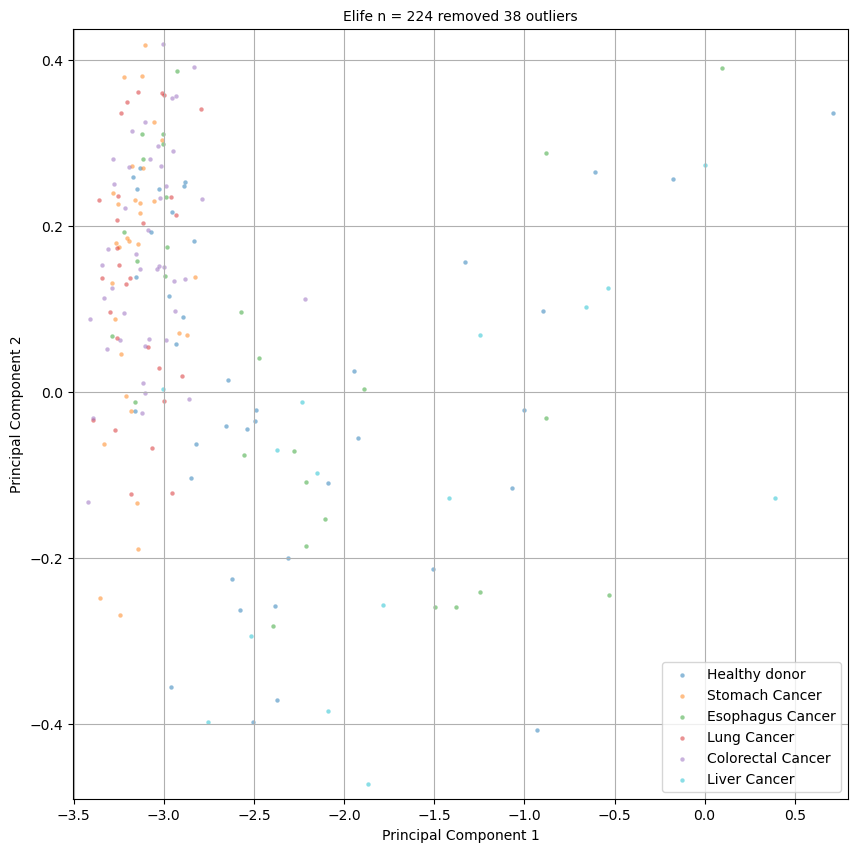

In [8]:
def plotAll(countDF, metaDF, allKinds, imgOut):
    '''
    TODO
    '''

    tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
    print(f'tmpMetaDF.shape : {tmpMetaDF.shape}')
    
    allXDF = selectSamples(tmpMetaDF, countDF, allKinds)
    print(f'allXDF.shape : {allXDF.shape}')

    # inner join on index
    # will have two extra cols 'sample_id', 'category'
    mergedDF = pd.merge(allXDF, tmpMetaDF, left_index=True, right_on='sample_id', how='inner')
    print(f'mergedDF.shape : {mergedDF.shape}')
    
    allXNP = mergedDF[ mergedDF.columns.difference(['sample_id', 'category']) ].values
    print(f'allXNP.shape : {allXNP.shape}')

    principalComponentsNP = runPCA(allXNP)
    mergedCategories = mergedDF.loc[:, 'category'].values 
    print(f'principalComponentsNP.shape {principalComponentsNP.shape } mergedCategories.shape {mergedCategories.shape}')
    noOutliersDF = removeOutLiers( principalComponentsNP, mergedCategories)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
    assert len(colors) == len(allKinds), f'ERROR len(colors) : {len(colors)} != len(allKinds): {len(allKinds)}'
    fig, pannel = createScatterPlot(
        # x = principalComponentsNP[:,0],
        # y = principalComponentsNP[:,1],
        x = noOutliersDF.loc[:, "x"].values,
        y = noOutliersDF.loc[:, "y"].values,
        #title = 'Elife n = 78 are not separable',
        title = f'Elife n = {principalComponentsNP.shape[0]} removed {principalComponentsNP.shape[0]- noOutliersDF.shape[0]} outliers',
        # title = f'Elife n = {principalComponentsNP.shape[0]}',
        xLabel = 'Principal Component 1',
        yLabel = 'Principal Component 2', 
        categories = noOutliersDF.loc[:, "category"].values,
        # colors  = ['r',  'b'],
        colors = colors,
        #figSize = (4,4), 
        figSize = (10,10), 
        #figSize = (15,15), 
        axisPaddingPrecentage = 0.02,
        #axisPaddingPrecentage = -0.01, # may clip some outliers
    )
    
    imgFilePath = imgOut + "/allElifePCA.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotAll(countDF, metaDF, allKinds, imgOut)

## Lung vs Healthy Donor

XDF.shape : (78, 76555)
mergedDF.shape : (78, 76557)
XNP.shape : (78, 76555)
XScaledNP.shape (78, 76555)
principalComponentsNP.shape (78, 2)


,x,y
count,7.800000e+01,7.800000e+01
mean,-8.312439e-16,7.856963e-16
std,2.173246e+01,8.080885e+00
min,-4.187879e+00,-1.207206e+01
5%,-4.116593e+00,-9.537592e+00
25%,-3.657953e+00,-6.318133e+00
50%,-3.243125e+00,-2.943709e+00
75%,-2.461667e+00,7.659983e+00
95%,7.247504e-01,1.422679e+01
max,1.869972e+02,2.022278e+01



upperXThreshold : 0.7247504070316028 upperYThreshold : 14.226789757577027 

lowerXThreshold : -4.116593438412062 lowerYThreshold : -9.53759178504813 

sum(selectXRows) : 70 sum(selectYRows) : 70 sum(selectRows) : 64
noOutliersDF.shape : (64, 3)
xmin: -4.110142490186891 xMax : 0.341197407927869
yMin: -9.427752278486588 yMax : 14.100820338054023
df.shape : (64, 3)
saved image to /private/groups/kimlab/aedavids/elife/lungCancerPCA_ClusterAnalysis.out/img/allElifeLungPCA.png


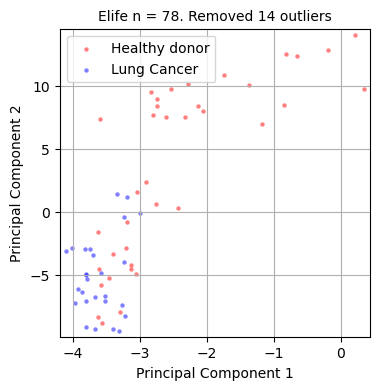

In [9]:
def plotLung(countDF, metaDF, imgOut):
    # select lung and healthy donnor sample
    listOfCategories = ["Healthy donor", "Lung Cancer"]
    tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
    # display( tmpMetaDF.head() )
    XDF = selectSamples(tmpMetaDF, countDF, listOfCategories)
    print(f'XDF.shape : {XDF.shape}')
    
    # inner join on index
    # will have two extra cols 'sample_id', 'category'
    mergedDF = pd.merge(XDF, tmpMetaDF, left_index=True, right_on='sample_id', how='inner')
    print(f'mergedDF.shape : {mergedDF.shape}')

    XNP = mergedDF[ mergedDF.columns.difference(['sample_id', 'category']) ].values
    print(f'XNP.shape : {XNP.shape}')

    mergedCategories = mergedDF.loc[:, 'category'].values 
    
    principalComponentsNP = runPCA(XNP)
    
    noOutliersDF = removeOutLiers( principalComponentsNP, mergedCategories )
    print(f'noOutliersDF.shape : {noOutliersDF.shape}')
    
    fig, pannel = createScatterPlot(
            # x = principalComponentsNP[:,0],
            # y = principalComponentsNP[:,1],
            x = noOutliersDF.loc[:, "x"].values,
            y = noOutliersDF.loc[:, "y"].values,
            #title = 'Elife n = 78 are not separable',
            title = f'Elife n = {principalComponentsNP.shape[0]}. Removed {principalComponentsNP.shape[0]- noOutliersDF.shape[0]} outliers',
            xLabel = 'Principal Component 1',
            yLabel = 'Principal Component 2', 
            categories = noOutliersDF.loc[:, "category"].values,
            colors  = ['r',  'b'],
            figSize = (4,4), 
            # figSize = (10,10), 
            #figSize = (15,15), 
            axisPaddingPrecentage = 0.02,
            #axisPaddingPrecentage = -0.01, # may clip some outliers
    )

    imgFilePath = imgOut + "/allElifeLungPCA.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotLung(countDF, metaDF, imgOut)

## Does clustering using on LUAD, LUSC, and Lung Intracelluar biomarkers work?
select biomarkers and remove missing genes

In [10]:
LUADGenes = findSignatureGenesForPipelineStage(category="LUAD", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'LUAD genes:\n{LUADGenes}')

LUSCGenes = findSignatureGenesForPipelineStage(category="LUSC", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'\nLUSC genes:\n{LUSCGenes}')

# Lung is our healthy control
controlGenes = findSignatureGenesForPipelineStage(category="Lung", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'\n healthy control Lung genes:\n{controlGenes}')

HUGO_lungGenes = LUADGenes + LUSCGenes + controlGenes
print(f'len(HUGO_lungGenes) {len(HUGO_lungGenes)}')

LUAD genes:
['AC011944.1', 'ATP13A4-AS1', 'AC090004.1', 'GXYLT1P3', 'AC126323.6', 'AC111149.2', 'AL365181.4', '(TCCAC)n', 'BPIFA2', 'IGHJ5']

LUSC genes:
['FMO6P', 'AC121493.1', 'AP001120.2', 'LINC01249', 'AP000344.1', '(TCTATG)n', 'AC092140.2', 'AP001360.1', 'ENPP7P11', 'AC018521.2']

 healthy control Lung genes:
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']
len(HUGO_lungGenes) 30


In [11]:
%%time
elifeLungGenes, missingElifeGenes = selectFeatures(countDF, HUGO_lungGenes)
print( f'len(elifeLungGenes) : {len(elifeLungGenes)}' )
print( f'missingElifeGenes\n : {missingElifeGenes}' )

# remove missing biomarkers
features = list( set(elifeLungGenes) - set(missingElifeGenes) )
assert len(features) == 29, "ERROR removing missing elife genes"

refSeq2ENSGDF.loc[selectRows, :] :
              HUGO               ENSG bioType
97713   AC111149.2  ENSG00000253339.2  lncRNA
172016  AC092140.2  ENSG00000274031.1  lncRNA
203145      PCAT19  ENSG00000267107.8  lncRNA
len(elifeLungGenes) : 30
missingElifeGenes
 : ['ENSG00000274031.1']
CPU times: user 30.6 s, sys: 3.64 s, total: 34.2 s
Wall time: 35.3 s


XDF.shape : (78, 29)
mergedDF.shape : (78, 31)
XNP.shape : (78, 29)
XScaledNP.shape (78, 29)
principalComponentsNP.shape (78, 2)


,x,y
count,7.800000e+01,7.800000e+01
mean,1.458947e-17,-1.427811e-17
std,5.128272e-01,1.984896e-01
min,-9.607364e-02,-2.816799e-01
5%,-9.466609e-02,-6.226406e-02
25%,-8.884813e-02,-1.699704e-02
50%,-8.472076e-02,-1.063146e-02
75%,-6.361038e-02,-7.387684e-03
95%,7.229827e-02,5.693891e-03
max,4.390662e+00,1.675509e+00



upperXThreshold : 0.07229827410387663 upperYThreshold : 0.0056938913293483025 

lowerXThreshold : -0.09466609446811984 lowerYThreshold : -0.06226406213403297 

sum(selectXRows) : 70 sum(selectYRows) : 70 sum(selectRows) : 66
noOutliersDF.shape : (66, 3)
xmin: -0.09465538740836131 xMax : -0.000179150370693004
yMin: -0.05227623417178787 yMax : 0.0045024370230836675
df.shape : (66, 3)
saved image to /private/groups/kimlab/aedavids/elife/lungCancerPCA_ClusterAnalysis.out/img/elifeHealthy_LungCancerPCA.png


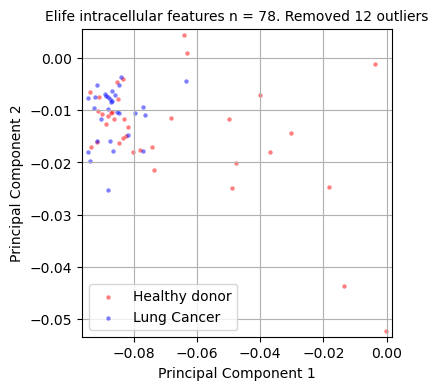

In [12]:
def plotLungIntracellularBiomarkersOnElifePlasma(countDF, metaDataDF, features):
    '''
    TODO
    '''
    listOfCategories = ["Healthy donor", "Lung Cancer"]
    tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
    # display( tmpMetaDF.head() )
    XDF = selectSamples(tmpMetaDF, countDF, listOfCategories)
    XDF = XDF.loc[:, features]

    print(f'XDF.shape : {XDF.shape}')

       # inner join on index
    # will have two extra cols 'sample_id', 'category'
    mergedDF = pd.merge(XDF, tmpMetaDF, left_index=True, right_on='sample_id', how='inner')
    print(f'mergedDF.shape : {mergedDF.shape}')

    XNP = mergedDF[ mergedDF.columns.difference(['sample_id', 'category']) ].values
    print(f'XNP.shape : {XNP.shape}')

    mergedCategories = mergedDF.loc[:, 'category'].values 
    
    principalComponentsNP = runPCA(XNP)

    noOutliersDF = removeOutLiers( principalComponentsNP, mergedCategories )
    print(f'noOutliersDF.shape : {noOutliersDF.shape}')
    
    fig, pannel = createScatterPlot(
            # x = principalComponentsNP[:,0],
            # y = principalComponentsNP[:,1],
            x = noOutliersDF.loc[:, "x"].values,
            y = noOutliersDF.loc[:, "y"].values,
            #title = 'Elife n = 78 are not separable',
            title = f'Elife intracellular features n = {principalComponentsNP.shape[0]}. Removed {principalComponentsNP.shape[0]- noOutliersDF.shape[0]} outliers',
            xLabel = 'Principal Component 1',
            yLabel = 'Principal Component 2', 
            categories = noOutliersDF.loc[:, "category"].values,
            colors  = ['r',  'b'],
            figSize = (4,4), 
            # figSize = (10,10), 
            #figSize = (15,15), 
            axisPaddingPrecentage = 0.02,
            #axisPaddingPrecentage = -0.01, # may clip some outliers
    )

    imgFilePath = imgOut + "/elifeHealthy_LungCancerPCA.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotLungIntracellularBiomarkersOnElifePlasma(countDF, metaDF, features)